# Spoint tutorial: Deconvolution of cell types composition on human brain Visium dataset

July 2023

Dataset: Visium slices of human dorsolateral prefrontal cortex ([here](https://zenodo.org/record/8167488)).

In [4]:
import torch
print("CUDA 可用性：", torch.cuda.is_available())
print("可用的 GPU 数量：", torch.cuda.device_count())


CUDA 可用性： True
可用的 GPU 数量： 4


In [5]:
import os,sys
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [6]:
from GraphCellNet.setting import set_environ_seed
set_environ_seed()
#from GraphCellNet import deconv

Global seed set to 0
/opt/conda/envs/SPACEL/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Setting environment seed: 42


In [7]:

import scanpy as sc
import numpy as np
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.serif'] = ['Arial']
sc.settings.set_figure_params(dpi=50,dpi_save=300,facecolor='white',fontsize=10,vector_friendly=True,figsize=(3,3))
sc.settings.verbosity = 3

## Load data

In [ ]:
sc_adata = sc.read_h5ad('/data/data/visium_human_DLPFC/human_MTG_snrna_norm_by_exon.h5ad')
adata = sc.read_h5ad('/data/stc_data/DLPFC/DLPFC_12_ST.h5ad')

sc.pp.filter_genes(adata,min_cells=1)
sc.pp.filter_genes(sc_adata,min_cells=1)
sc.pp.filter_cells(adata,min_genes=1)
sc.pp.filter_cells(sc_adata,min_genes=1)

filtered out 32 genes that are detected in less than 1 cells


In [9]:
sc_adata

AnnData object with n_obs × n_vars = 47432 × 48507
    obs: 'cluster_label', 'class_label', 'subclass_label', 'cortical_layer_label', 'n_genes'
    var: 'n_cells', 'gene_length', 'exon_len'

In [10]:
sc_adata.obs

,cluster_label,class_label,subclass_label,cortical_layer_label,n_genes
exp_component_name,,,,,
LS-15005h_S02_E1-50,Inh L2-5 VIP TOX2,GABAergic,VIP,L1,4747
LS-15005h_S03_E1-50,Inh L1 LAMP5 GGT8P,GABAergic,LAMP5,L1,3807
LS-15005h_S04_E1-50,Inh L1 LAMP5 NDNF,GABAergic,LAMP5,L1,3539
LS-15005h_S05_E1-50,Inh L1-3 VIP ZNF322P1,GABAergic,VIP,L1,4577
LS-15005h_S06_E1-50,Inh L3 VIP CBLN1,GABAergic,VIP,L1,3227
...,...,...,...,...,...
SQ-80016_S92_E1-50,Inh L1-3 PAX6 NABP1,GABAergic,PAX6,L2,6158
SQ-80016_S93_E1-50,Exc L2-3 LINC00507 RPL9P17,Glutamatergic,IT,L2,4298
SQ-80016_S94_E1-50,Exc L2-3 LINC00507 RPL9P17,Glutamatergic,IT,L2,5273


In [11]:
adata

AnnData object with n_obs × n_vars = 47681 × 5207
    obs: 'in_tissue', 'array_row', 'array_col', 'imagecol', 'imagerow', 'GT', 'slice', 'n_genes', 'batch', 'Exc L2-3 LINC00507 RPL9P17', 'Exc L6 THEMIS LINC00343', 'Exc L4-5 RORB LINC01474', 'Exc L4-5 RORB RPL31P31', 'Oligo L4-6 OPALIN', 'Exc L2-4 RORB GRIK1', 'Exc L4-5 RORB LCN15', 'Exc L4 RORB BHLHE22', 'Exc L6 FEZF2 FAM95C', 'Inh L3-5 SST MAFB', 'Astro L1-6 FGFR3 ETNPPL', 'Exc L3-4 RORB PRSS12', 'Exc L6 THEMIS EGR3', 'Inh L2-4 PVALB C8orf4', 'Inh L1-4 LAMP5 DUSP4', 'OPC L1-6 MYT1', 'Exc L6 FEZF2 VWA2', 'Micro L1-6 C1QC', 'Inh L4-6 SST MTHFD2P6', 'Inh L1 LAMP5 NDNF', 'Exc L6 FEZF2 KRT17', 'Exc L3-5 RORB CMAHP', 'Exc L5-6 FEZF2 MYBPHL', 'Inh L5 PVALB CNTNAP3P2', 'Exc L5-6 THEMIS GPR21', 'Inh L1-3 VIP ZNF322P1', 'Exc L3-4 RORB SEMA6D', 'Inh L1 ADARB2 ADAM33', 'Exc L4-5 RORB HNRNPA1P46', 'Exc L4 RORB CACNG5', 'Inh L5-6 LAMP5 SFTA3', 'Exc L5 RORB SNHG7', 'Exc L5-6 THEMIS IL7R', 'Inh L3-4 PVALB HOMER3', 'Exc L3-4 RORB FOLH1B', 'Exc L3 LINC

In [14]:
from GraphCellNet import model


In [ ]:
model = model.init_model(sc_adata,adata,celltype_key='cluster_label',deg_method='t-test',sm_size=100000,use_gpu=True)

Setting global seed: 42
normalizing counts per cell
    finished (0:00:01)
normalizing counts per cell
    finished (0:00:00)
### Finding marker genes...
ranking genes


In [ ]:
model.train(max_steps=8000, save_path='/data/tutorials/data', batch_size=1024)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A40') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 100/100: 100%|██████████| 100/100 [12:03<00:00,  8.24s/it, loss=1.46e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [12:03<00:00,  7.23s/it, loss=1.46e+03, v_num=1]


Step 3991: Test inference loss=-0.244: 100%|██████████| 4000/4000 [27:46<00:00,  2.40it/s]

Training completed in 1666.87 seconds with memory usage 11312.55 MB.


## results

In [ ]:
pre = model.deconv_spatial()

In [ ]:
st_ad = model.st_ad

In [ ]:
st_ad.write('/data/data/visium_human_DLPFC/st_ad1106.h5ad')


In [ ]:

st_ad.obs['slice'] = st_ad.obs['slice'].astype(int)

slice_to_sample_name = {
    0: '151507',
    1: '151508',
    2: '151509',
    3: '151510',
    4: '151669',
    5: '151670',
    6: '151671',
    7: '151672',
    8: '151673',
    9: '151674',
    10: '151675',
    11: '151676'
}


st_ad.obs['sample_name'] = st_ad.obs['slice'].map(slice_to_sample_name)


print(st_ad.obs[['slice', 'sample_name']].head())


                      slice sample_name
AAACAACGAATAGTTC-1-0      0      151507
AAACAAGTATCTCCCA-1-0      0      151507
AAACAATCTACTAGCA-1-0      0      151507
AAACACCAATAACTGC-1-0      0      151507
AAACAGCTTTCAGAAG-1-0      0      151507


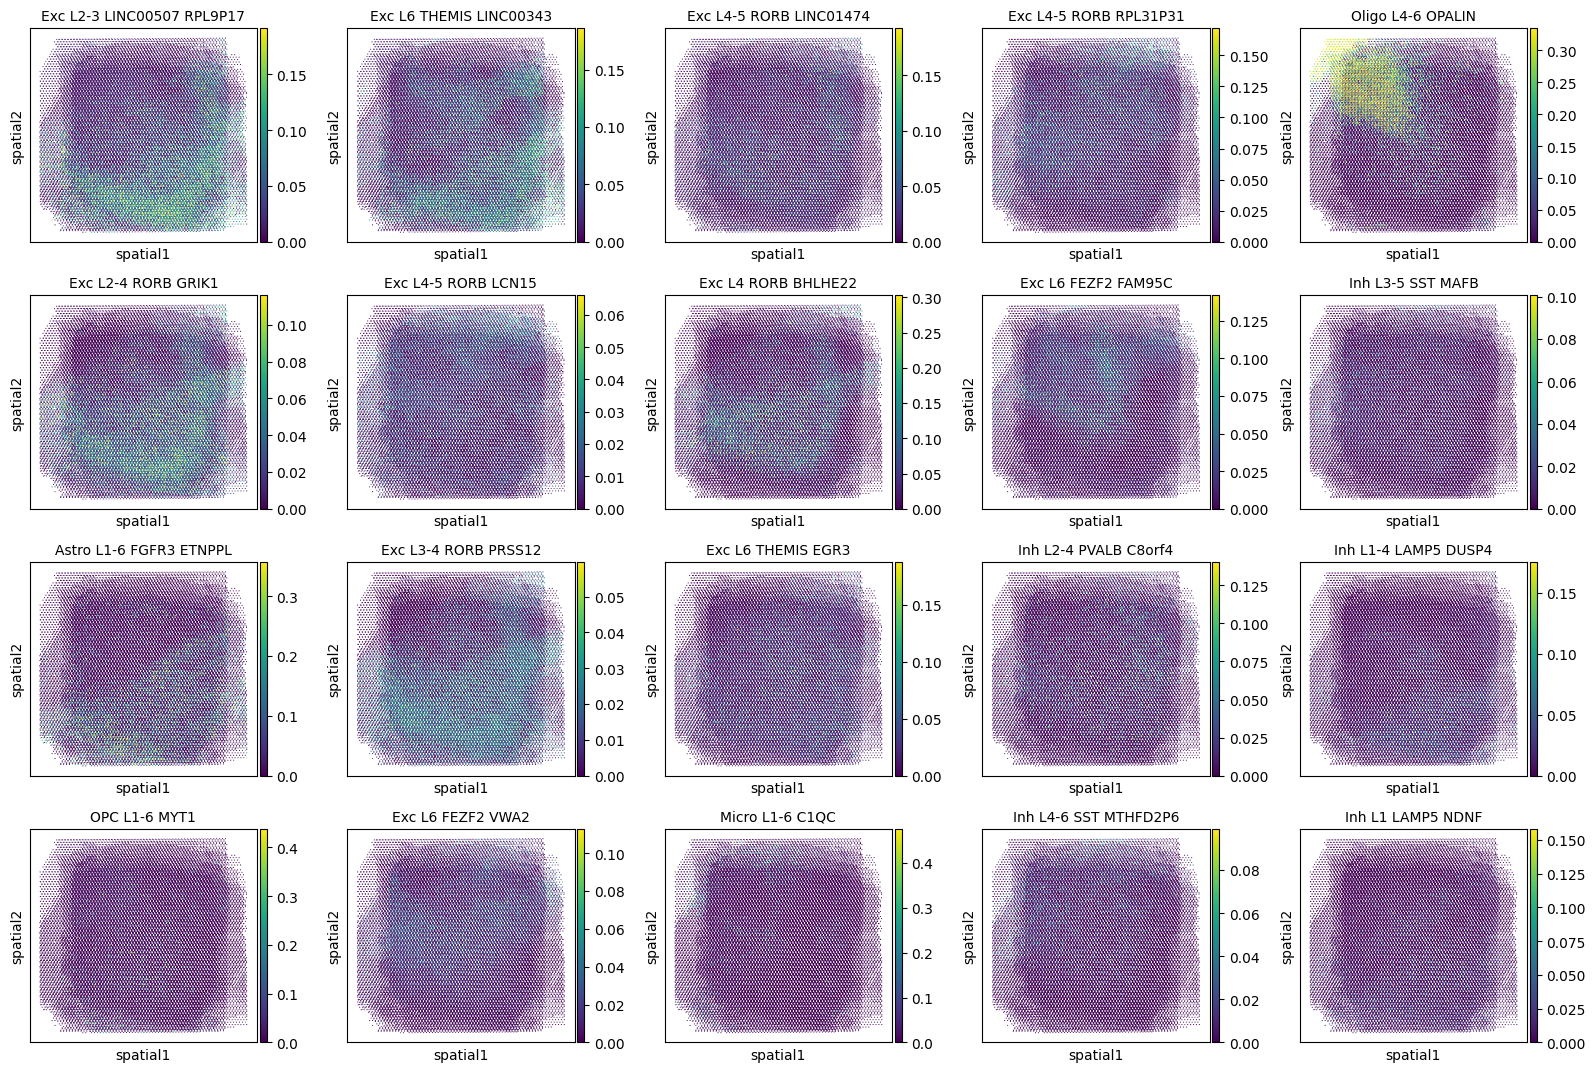

In [17]:
import scanpy as sc
sc.pl.embedding(st_ad,color=pre.columns[:20],basis='spatial',ncols=5)

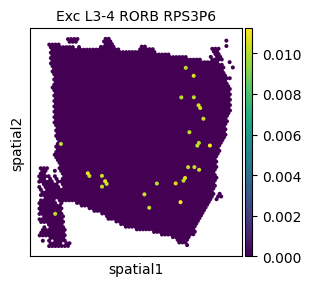

In [18]:
# 确保使用正确的列名
st_ad_151675 = st_ad[st_ad.obs['sample_name'] == '151675']
sc.pl.embedding(st_ad_151675, color='Exc L3-4 RORB RPS3P6', basis='spatial', ncols=5)